 # Import

In [9]:
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [1]:
# %%
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..', ''))
NON_ICM_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'NON_ICM'))
ICM_dir = os.path.abspath(os.path.join(os.getcwd(), '..', 'ICM_Integrated'))
sys.path.append(parent_dir)
sys.path.append(NON_ICM_dir)
sys.path.append(ICM_dir)


In [2]:
# %%
# from Basic_Leduc_Game import LeducholdemGame
from Game_Env import LeducholdemEnv
# Import agent class
from ICM_Integrated.ICM_EA_MCCFR_Agent import ICM_EA_MCCFR_Agent
from ICM_Integrated.ICM_TA_MCCFR_Agent import ICM_TA_MCCFR_Agent
from NON_ICM.NonICM_EA_MCCFR_Agent import NonICM_EA_MCCFR_Agent
from NON_ICM.NonICM_TA_MCCFR_Agent import NonICM_TA_MCCFR_Agent



 # Matches Functions

In [4]:
"""Set up the environment for the competition with the provided configuration."""
def env_set(config):
    env = LeducholdemEnv(config=config)
    print(">> Matches environment and game configures set.")
    return env

"""Load agents with the provided model paths into the given environment."""
def load_agents(env, model_paths):
    '''
    Parameters:
        - env: The environment where the agents will be loaded.
        - model_paths: A dictionary containing the model paths for the agents.
    Returns:
        A dictionary of loaded agents.
    '''
    player_nonicm_ea = NonICM_EA_MCCFR_Agent(env, model_path=model_paths['player_nonicm_ea'])
    player_nonicm_ea.load()
    
    player_nonicm_ta = NonICM_TA_MCCFR_Agent(env, model_path=model_paths['player_nonicm_ta'])
    player_nonicm_ta.load()
    
    player_icm_ea = ICM_EA_MCCFR_Agent(env, model_path=model_paths['player_icm_ea'])
    player_icm_ea.load()
    
    player_icm_ta = ICM_TA_MCCFR_Agent(env, model_path=model_paths['player_icm_ta'])
    player_icm_ta.load()


    print(">> Agents loaded.")
    return {
        'player_nonicm_ea': player_nonicm_ea,
        'player_nonicm_ta': player_nonicm_ta,
        'player_icm_ea': player_icm_ea,
        'player_icm_ta': player_icm_ta,
    }

"""Set the agents for the environment.""" 
def set_agents(env, agents):
    '''
    Parameters:
    - env: The environment where the agents will be set.
    - agents: A list of agents to be set in the environment.
    '''
    env.set_agents(agents)
    print(f">> {type(agents[0])} and {type(agents[1])} set in environment.")

In [6]:
def matches_run(rounds, hands, env, initial_chips, small_blind_multiplier):
    # 
    all_p1_wealth = {}
    all_p2_wealth = {}
    all_p1_wins = {}
    all_p2_wins = {}
    all_p1_wins_prob = {}
    all_p2_wins_prob = {}
    all_p1_payoffs = {}
    all_p2_payoffs = {}
    all_trajectories = {}

    for i in range(rounds):
        
        # Initialize wealth and win counters for each iteration
        p1_wealth = initial_chips
        p2_wealth = initial_chips
        p1_wins = 0
        p2_wins = 0
        p1_wealth_list = []
        p2_wealth_list = []
        small_blind = 1
        p1_payoffs = []
        p2_payoffs = []
        trajectories_list =[]
        
        while len(p1_wealth_list) < hands:
            # Check if either player needs to be reset before starting a new hand
            if p1_wealth <= 0 or p2_wealth <= 0 or p1_wealth < small_blind * 8 or p2_wealth < small_blind * 8:
                p1_wealth = initial_chips
                p2_wealth = initial_chips
                small_blind = 1
            
            # 设置当前轮的盲注
            env.game.small_blind = small_blind
            env.game.big_blind = 2 * small_blind
            env.game.raise_amount = env.game.big_blind

            # 运行游戏
            trajectories, payoffs = env.run(is_training=False)
            p1_payoffs.append(payoffs[0])
            p2_payoffs.append(payoffs[1])
            trajectories_list.append(trajectories)

            # 计算赢局数
            if payoffs[0] > 0:
                p1_wins += 1
            else:
                p2_wins += 1

            # 更新财富值
            p1_wealth += payoffs[0]
            p2_wealth += payoffs[1]

            # Append cumulative wealth to lists
            p1_wealth_list.append(p1_wealth)
            p2_wealth_list.append(p2_wealth)

            # Double the small blind
            small_blind *= small_blind_multiplier

        all_p1_wealth[i+1] = p1_wealth_list
        all_p2_wealth[i+1] = p2_wealth_list
        all_p1_wins[i+1] = p1_wins
        all_p2_wins[i+1] = p2_wins
        all_p1_wins_prob[i+1] = p1_wins/(p1_wins+p2_wins)
        all_p2_wins_prob[i+1] = p2_wins/(p1_wins+p2_wins)
        all_p1_payoffs[i+1] = p1_payoffs
        all_p2_payoffs[i+1] = p2_payoffs
        all_trajectories[i+1] = trajectories_list

    print(">> Competition finished.")
    return all_p1_wealth, all_p2_wealth, all_p1_wins, all_p2_wins, all_p1_wins_prob, all_p2_wins_prob, all_p1_payoffs, all_p2_payoffs, all_trajectories


 # Play game - NonICM ea vs ICM ea

In [7]:
env = env_set(config={'allow_step_back':True,
                'small_blind': 1,
                'allowed_raise_num': 2,
                'seed':42})

model_paths = {
    'player_nonicm_ea': './NON_ICM/nonicm_ea_mccfr_agent',
    'player_nonicm_ta': './NON_ICM/nonicm_ta_mccfr_agent',
    'player_icm_ea': './ICM_Integrated/icm_ea_mccfr_agent',
    'player_icm_ta': './ICM_Integrated/icm_ta_mccfr_agent'
}
agents = load_agents(env, model_paths)

set_agents(env, [agents['player_nonicm_ea'], agents['player_icm_ea']])

#  Run matches
all_p1_wealth, all_p2_wealth, all_p1_wins, all_p2_wins, all_p1_wins_prob, all_p2_wins_prob, all_p1_payoffs, all_p2_payoffs, all_trajectories = matches_run(rounds=20,hands=1000,env=env,initial_chips=1000,small_blind_multiplier=1)


>> Matches environment and game configures set.
>> Agents loaded.
>> <class 'NON_ICM.NonICM_EA_MCCFR_Agent.NonICM_EA_MCCFR_Agent'> and <class 'ICM_Integrated.ICM_EA_MCCFR_Agent.ICM_EA_MCCFR_Agent'> set in environment.
>> Competition finished.


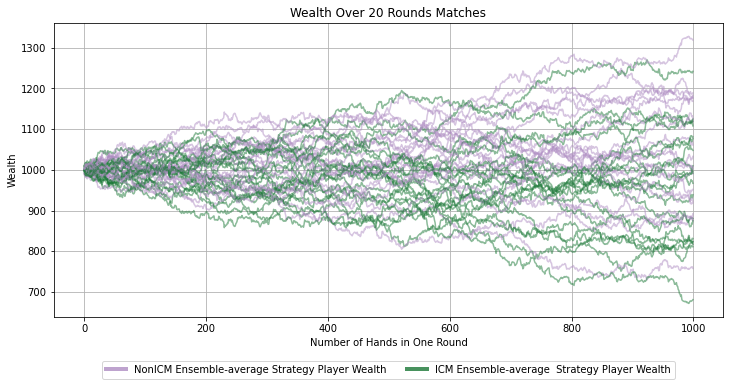

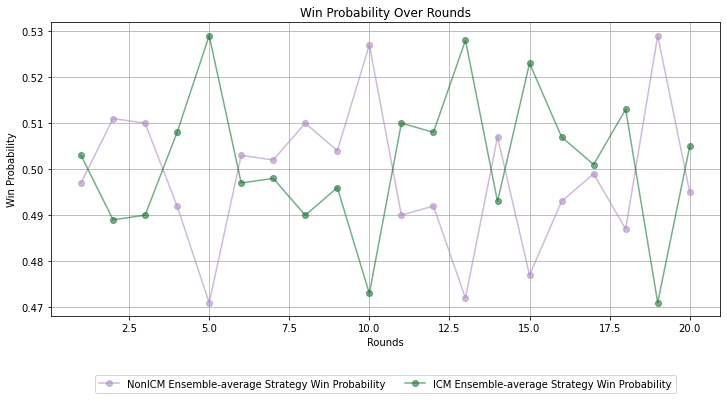

In [10]:
# %%
# Line plot for wealth change

plt.figure(figsize=(12, 6))

for round_num in all_p1_wealth:
    plt.plot(all_p1_wealth[round_num], color='#af8dc3', alpha=0.5)
    plt.plot(all_p2_wealth[round_num], color='#1b7837', alpha=0.5)
custom_lines = [
    Line2D([0], [0], lw=4, color='#af8dc3', alpha=0.8),
    Line2D([0], [0], lw=4, color='#1b7837', alpha=0.8)
]
plt.legend(custom_lines, ['NonICM Ensemble-average Strategy Player Wealth', 'ICM Ensemble-average  Strategy Player Wealth'], 
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, borderaxespad=0.)

plt.title(f'Wealth Over {len(all_p1_wealth)} Rounds Matches')
plt.xlabel('Number of Hands in One Round')
plt.ylabel('Wealth')
plt.subplots_adjust(bottom=0.2)
plt.grid(True)
plt.show()


# Line plot for win prob.
# data preparation

round_nums = list(all_p1_wins_prob.keys())
p1_win_probs = [all_p1_wins_prob[round_num] for round_num in round_nums]
p2_win_probs = [all_p2_wins_prob[round_num] for round_num in round_nums]
# fig
plt.figure(figsize=(12, 6))
plt.plot(round_nums, p1_win_probs, label='NonICM Ensemble-average Strategy Win Probability', marker='o', color='#af8dc3', alpha=0.6)
plt.plot(round_nums, p2_win_probs, label='ICM Ensemble-average Strategy Win Probability', marker='o',color='#1b7837', alpha=0.6)

plt.title('Win Probability Over Rounds')
plt.xlabel('Rounds')
plt.ylabel('Win Probability')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, borderaxespad=0.)
plt.subplots_adjust(bottom=0.2)
plt.grid(True)
plt.show()





 # Play game - NonICM ta vs ICM ta

In [11]:
# Set up
env = env_set(config={'allow_step_back':True,
                'small_blind': 1,
                'allowed_raise_num': 2,
                'seed':42})

model_paths = {
    'player_nonicm_ea': './NON_ICM/nonicm_ea_mccfr_agent',
    'player_nonicm_ta': './NON_ICM/nonicm_ta_mccfr_agent',
    'player_icm_ea': './ICM_Integrated/icm_ea_mccfr_agent',
    'player_icm_ta': './ICM_Integrated/icm_ta_mccfr_agent'
}
agents = load_agents(env, model_paths)

set_agents(env, [agents['player_nonicm_ta'], agents['player_icm_ta']])

#  Run matches
all_p1_wealth, all_p2_wealth, all_p1_wins, all_p2_wins, all_p1_wins_prob, all_p2_wins_prob, all_p1_payoffs, all_p2_payoffs, all_trajectories = matches_run(rounds=20,hands=1000,env=env,initial_chips=1000,small_blind_multiplier=1)


>> Matches environment and game configures set.
>> Agents loaded.
>> <class 'NON_ICM.NonICM_TA_MCCFR_Agent.NonICM_TA_MCCFR_Agent'> and <class 'ICM_Integrated.ICM_TA_MCCFR_Agent.ICM_TA_MCCFR_Agent'> set in environment.
>> Competition finished.


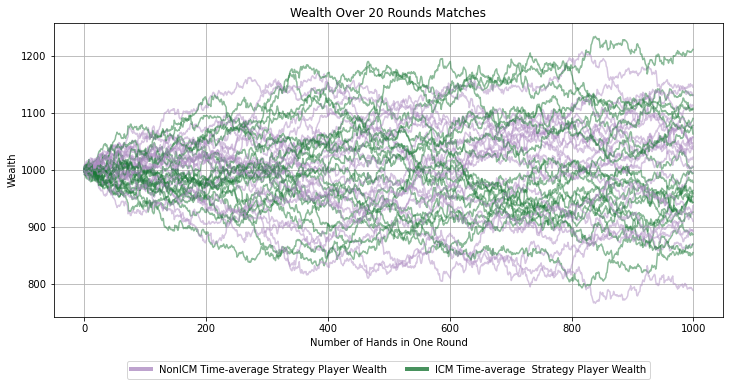

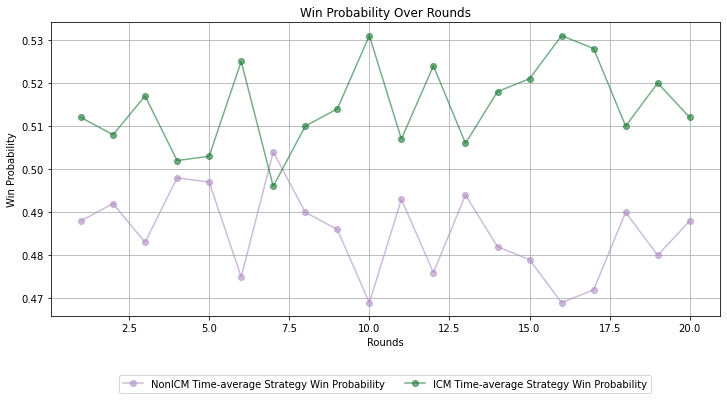

In [12]:
# %%
# Line plot for wealth change

plt.figure(figsize=(12, 6))

for round_num in all_p1_wealth:
    plt.plot(all_p1_wealth[round_num], color='#af8dc3', alpha=0.5)
    plt.plot(all_p2_wealth[round_num], color='#1b7837', alpha=0.5)
custom_lines = [
    Line2D([0], [0], color='#af8dc3', lw=4, alpha=0.8),
    Line2D([0], [0], color='#1b7837', lw=4, alpha=0.8)
]
plt.legend(custom_lines, ['NonICM Time-average Strategy Player Wealth', 'ICM Time-average  Strategy Player Wealth'], 
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, borderaxespad=0.)

plt.title(f'Wealth Over {len(all_p1_wealth)} Rounds Matches')
plt.xlabel('Number of Hands in One Round')
plt.ylabel('Wealth')
plt.subplots_adjust(bottom=0.2)
plt.grid(True)
plt.show()


# Line plot for win prob.
# data preparation

round_nums = list(all_p1_wins_prob.keys())
p1_win_probs = [all_p1_wins_prob[round_num] for round_num in round_nums]
p2_win_probs = [all_p2_wins_prob[round_num] for round_num in round_nums]
# fig
plt.figure(figsize=(12, 6))
plt.plot(round_nums, p1_win_probs, label='NonICM Time-average Strategy Win Probability', color='#af8dc3', marker='o',alpha=0.6)
plt.plot(round_nums, p2_win_probs, label='ICM Time-average Strategy Win Probability', color='#1b7837', marker='o',alpha=0.6)

plt.title('Win Probability Over Rounds')
plt.xlabel('Rounds')
plt.ylabel('Win Probability')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2, borderaxespad=0.)
plt.subplots_adjust(bottom=0.2)
plt.grid(True)
plt.show()